$$\renewcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\renewcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\renewcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

In [1]:
# Uncomment the following line to install the required packages if not already installed
# !pip install qiskit qiskit-aer qiskit-ibm-runtime matplotlib pylatexenc qiskit-ibm-transpiler[ai-local-mode]

# Quantum Walks and Monte Carlo

## Part I - Universal Statistical Simulator Understanding

The 2-pager description of the approach to achieve various distributions with Quantum Galton Board can be found here: [solution summary](solution_summary.md).

## Part II - General Algorithm for Quantum Galton Box

In [2]:
from typing import List, Tuple

import math
import numpy as np
from collections import defaultdict

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_ibm_runtime import SamplerV2 as IBMSampler

import matplotlib.pyplot as plt

from circuit_runner import RunMode, run_simulation
from distributions import DistributionGenerator, DistributionType

In [3]:
SHOTS = 4096
ENABLE_REAL_DEVICE = False
results = {}

In [4]:
def calculate_wire_tuples(n, level) -> List[Tuple[int, int]]:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    middle = n + 1
    start, finish = middle - level, middle + level
    return [(i, i + 1) for i in range(start, finish)]

def create_qgb_circuit(n, coin) -> QuantumCircuit:
    """Creates a quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    def qpegs(qc: QuantumCircuit, wire_tuples: List[Tuple[int]]):
        """Apply the quantum pegs operation for the Galton Board."""
        for i, wires in enumerate(wire_tuples):
            qc.cswap(0, wires[0], wires[1])
            if i < len(wire_tuples) - 1:
                qc.cx(wires[1], 0)


    def levels(qc: QuantumCircuit):
        """Apply the quantum pegs for each level of the Galton Board."""
        qc.x(n + 1)
        for level in range(1, n + 1):
            coin(qc, n, level)
            qpegs(qc, calculate_wire_tuples(n, level))
            if level < n:
                qc.reset(0)
            qc.barrier()

    def measures(qc: QuantumCircuit):
        """Final measurement of tally qubits"""
        for cbit, qbit in enumerate(range(1, 2 * n + 2, 2)):
            qc.measure(qbit, cbit)

    quantum_coin = QuantumRegister(1, "coin")
    qgb = QuantumRegister(2 * n + 1, "QGB")
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(
        quantum_coin, qgb, distribution, name="Quantum Galton Board"
    )
    levels(circuit)
    measures(circuit)
    return circuit

In [5]:
def hadamard_coin(qc: QuantumCircuit, n: int, level: int):
    """Applies a Hadamard coin operation for the Quantum Galton Board."""
    qc.h(0)

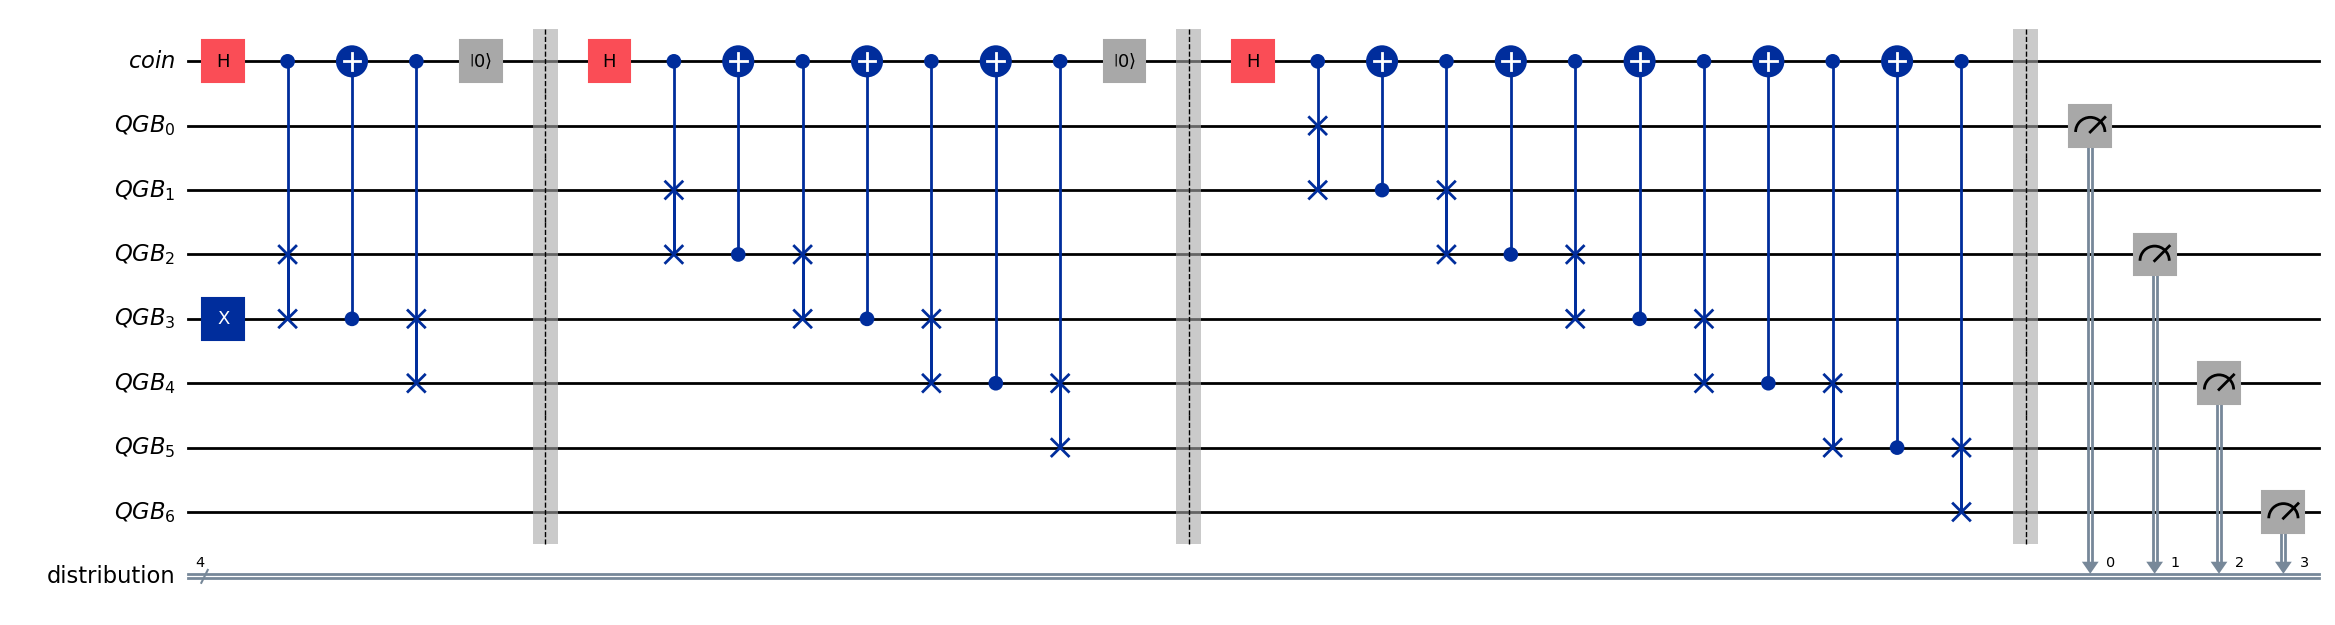

In [6]:
qc = create_qgb_circuit(3, hadamard_coin)
qc.draw("mpl", fold=-1)

In the circuit_runner.py helper module, we defined a function that will run the appropriate simulation of our circuit. It will leverage CircuitRunner class to execute the circuits, get the results and plot them against the reference distribution. `DistributionGenerator` class is used to calculate the perfect case of reference distributions. It supports normal, exponential, hadamard random walk and uniform distribution generation.

Width and depth of transpiled circuit: 21, 90


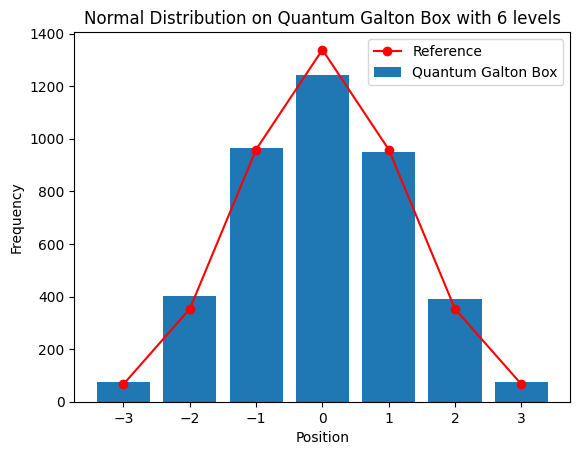

In [7]:
n = 6
results["gaussian_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_qgb_circuit,
    hadamard_coin,
    RunMode.NOISELESS_SIMULATOR,
    DistributionType.NORMAL,
    f"Normal Distribution on Quantum Galton Box with {n} levels",
)

Our implementation is fairly generic and allows easy introduction of custom coins that control the distribution. As an example, we could have a biased distribution with RY-rotation coin as demonstrated below.

Width and depth of transpiled circuit: 21, 90


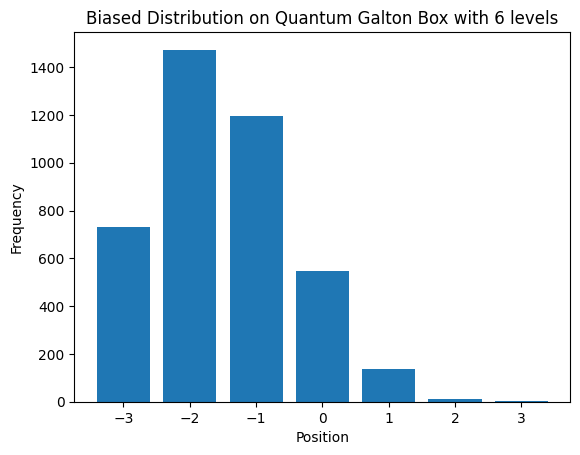

In [8]:
coin_function = lambda qc, n, level: qc.ry(2 * np.pi / 3, 0)
n = 6
_ = run_simulation(
    n,
    SHOTS,
    create_qgb_circuit,
    coin_function,
    RunMode.NOISELESS_SIMULATOR,
    title=f"Biased Distribution on Quantum Galton Box with {n} levels",
    show_reference=False,
)

## Part III - Modified Target Distributions

As mentioned in Part II, we are able to introduce different coins in order to modify the output distribution of our Quantum Galton Box. In this part, we will generate Exponential Distribution and Hadamard Quantum Walk.

### Exponential Distribution

Let's now create an exponential coin that modifies the righmost peg on each level. We will condition its rotation on the appropriate qubit for each level.

In [9]:
def exponential_coin(qc: QuantumCircuit, n, level):
    """Applies an exponential coin rotation based on the level."""
    theta = 2 * math.acos(np.sqrt(1 / np.e))
    if level == 1:
        qc.ry(theta, 0)
    else:
        middle = n + 1
        for i in range(middle - level + 1, middle + level - 1):
            qc.cx(i, 0)
        qc.cry(theta, middle + level - 1, 0)

Width and depth of transpiled circuit: 21, 120


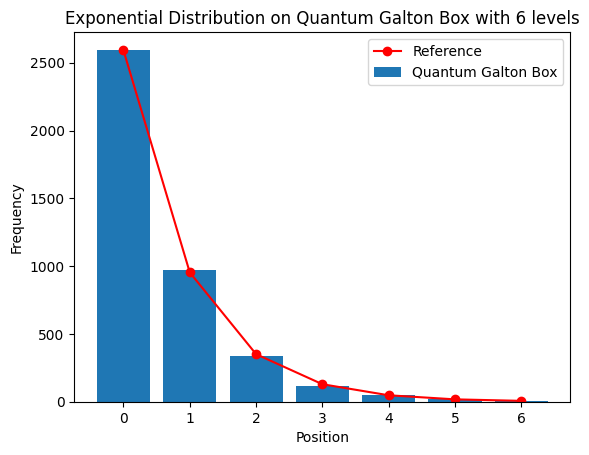

In [10]:
n = 6
results["exponential_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_qgb_circuit,
    exponential_coin,
    RunMode.NOISELESS_SIMULATOR,
    distribution_type=DistributionType.EXPONENTIAL,
    title=f"Exponential Distribution on Quantum Galton Box with {n} levels",
)

### Hadamard Quantum Walk

We modify the QGB circuit to simultaneously shift the ball left and right (controlled by the coin state). It removes the need to apply CNOT between the controlled-SWAP operations, but we now have to control it both on 0 and 1 values of the coin.

In [11]:
def calculate_hrw_wire_tuples(n, level) -> List[Tuple[int, int]]:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    middle = n + 1
    return [(i, i + 1) for i in range(middle - level, middle + level)]


def calculate_hrw_fs_wire_tuples(n) -> List[Tuple[int, int]]:
    iterations = math.floor((n + 1) / 2)
    return [(i * 2 + 1, 2 * n + 2 - (i * 2) - 1) for i in range(iterations)]


def create_hrw_qgb_circuit(n, coin) -> QuantumCircuit:
    """Creates a quantum circuit for the n-steps Hadamard Walk distribution
    leveraging the Quantum Galton Board (QGB) with n levels."""

    def qpegs(qc: QuantumCircuit, wire_tuples):
        control_value = 0
        print(len(wire_tuples))
        for wires in wire_tuples:
            qc.cswap(0, wires[0], wires[1], ctrl_state=control_value)
            control_value ^= 1

    def levels(qc: QuantumCircuit):
        qc.x(n + 1)
        for level in range(1, n + 1):
            coin(qc, n, level)
            qpegs(qc, calculate_hrw_wire_tuples(n, level))
            qc.barrier()

    def final_swap(qc: QuantumCircuit):
        qc.reset(0)
        qc.h(0)
        for wires in calculate_hrw_fs_wire_tuples(n):
            qc.cswap(0, wires[0], wires[1])
        qc.barrier()

    def measures(qc: QuantumCircuit):
        for cbit, qbit in enumerate(range(1, 2 * n + 2, 2)):
            qc.measure(qbit, cbit)

    qr = QuantumRegister(2 * n + 2)
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(qr, distribution)
    levels(circuit)
    final_swap(circuit)
    measures(circuit)
    return circuit

2
4
6


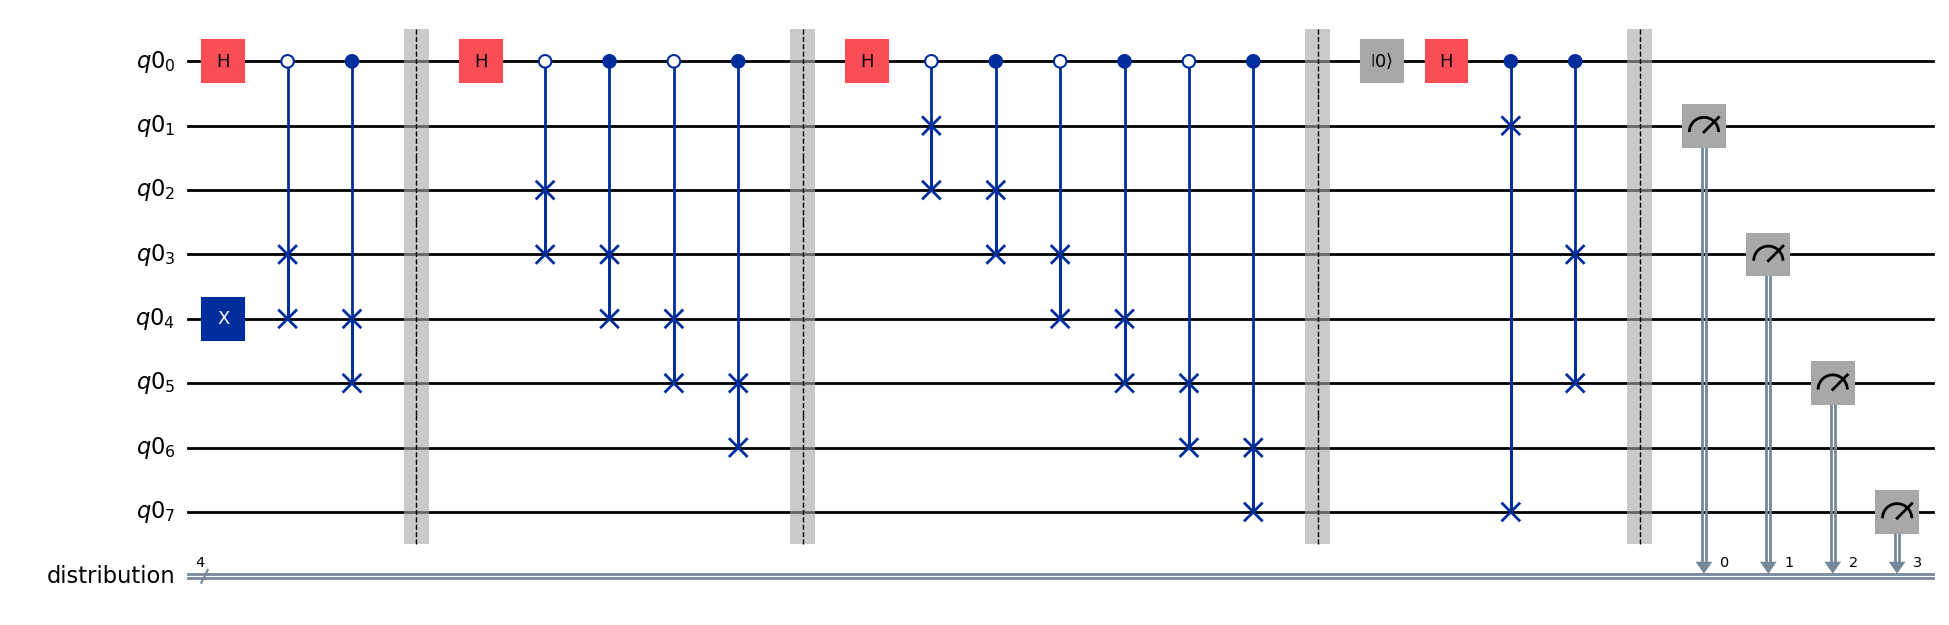

In [12]:
circuit = create_hrw_qgb_circuit(3, hadamard_coin)
circuit.draw("mpl", fold=-1)

2
4
6
8
10
12
Width and depth of transpiled circuit: 21, 90


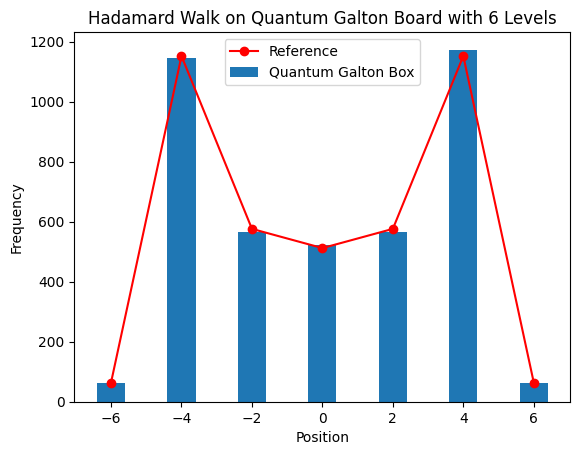

In [13]:
n = 6
results["hadamard_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_hrw_qgb_circuit,
    hadamard_coin,
    RunMode.NOISELESS_SIMULATOR,
    distribution_type=DistributionType.HADAMARD,
    title=f"Hadamard Walk on Quantum Galton Board with {n} Levels",
)

## Part IV - Optimization under Noise Models

Having our implementation working on the noiseless simulators, we will now work on exploring the circuit under a noise model.

In [14]:
service = QiskitRuntimeService()
real_torino = service.backend("ibm_torino")
real_brisbane = service.backend("ibm_brisbane")
least_busy_backend = service.least_busy()
print(f"torino qubits: {real_torino.num_qubits}, brisbane qubits: {real_brisbane.num_qubits}")
print(f"least busy backend: {least_busy_backend.name}, qubits: {least_busy_backend.num_qubits}")

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-07-28 22:49:37,403: Default instance not set. Searching all available instances.


torino qubits: 133, brisbane qubits: 127
least busy backend: ibm_sherbrooke, qubits: 127


After careful observations of the Galton board properties, it is possible to create a universal distribution simulator and optimize the use of qubits. The naive implementation requires $2n+2$ qubits. We can load any distribution using only $n+3$ qubits. It is worth noting that Galton board produced a superposition of all states with Hamming Weight 1 (single qubit is 1 and the rest are 0). For example, in case of 3 levels Galton board, we have 3 tally bin qubits and the resulting state will be $\alpha\ket{001} + \beta\ket{010} + \gamma\ket{100}$ (or $\alpha\ket{1}_3 + \beta\ket{2}_3 + \gamma\ket{4}_3$ in a more compact notation) for some arbitrary distribution. In a more general case, we can write it as:

$\ket{\psi} = \sum_{i=0}^{n}{\sqrt{p(i)}\ket{2^i}}_{n+1}$

$\sum_{i=0}^{n}{p(i)} = 1$

$\forall i\:\:p(i) >= 0$

In [15]:
def optimized_coin(qc: QuantumCircuit, n, level, probs: np.ndarray):
    """Applies the required coin rotation based on the level."""
    if level == 1:
        prob = probs[0]
        theta = 2 * math.acos(np.sqrt(1-prob))
        qc.ry(theta, 0)
    else:
        prob = probs[level - 1] / probs[(level-1):].sum()
        theta = 2 * math.acos(np.sqrt(1-prob))
        qc.cry(theta, level + 1, 0)

def calculate_opt_wire_tuples(n, level) -> List[Tuple[int, int]]:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    return [(i, i + 1) for i in range(level, level + 2)]


def create_opt_qgb_circuit(n, coin, probs: list | np.ndarray) -> QuantumCircuit:
    """Creates an optimized quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    if isinstance(probs, list):
        my_probs  = np.array(probs)
    else:
        my_probs = probs
    def qpegs(qc: QuantumCircuit, wire_tuples: List[Tuple[int]]):
        for i, wires in enumerate(wire_tuples):
            qc.cswap(0, wires[0], wires[1])
            if i < len(wire_tuples) - 1:
                qc.cx(wires[1], 0)

    def levels(qc: QuantumCircuit):
        qc.x(2)
        for level in range(1, n + 1):
            coin(qc, n, level, my_probs)
            qpegs(qc, wire_tuples=calculate_opt_wire_tuples(n, level))
            if level < n:
                qc.reset(0)
            qc.barrier()

    def measures(qc: QuantumCircuit):
        for cbit, qbit in enumerate(list(range(1, n + 1)) + [n + 2]):
            qc.measure(qbit, cbit)

    qr = QuantumRegister(n + 3)
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(qr, distribution)
    levels(circuit)
    measures(circuit)
    return circuit

Let's now apply the optimized circuit approach to the three distributions we are studying: Gaussian, Exponential and Hadamard Random Walk.

We will run all the distribution generations under the following three simulations:
- Noiseless AER simulator
- Noisy Simulator with noise model from the `ibm_torino` QPU backend
- Real device (IBM Torino)

We set the $n$ levels for all noisy simulations to be equal to check how each distribution holds under the same conditions.

In [16]:
n = 10
dg = DistributionGenerator(n, SHOTS)

### Gaussian Distribution

Below, we generate the Gaussian probabilities and execute the simulations storing the result for further comparison.


Width and depth of transpiled circuit: 24, 50


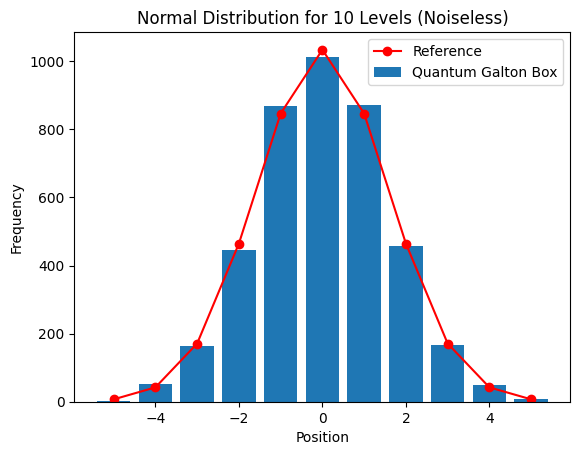

Width and depth of transpiled circuit: 144, 1177
Width and depth after AI Pass: 144, 867


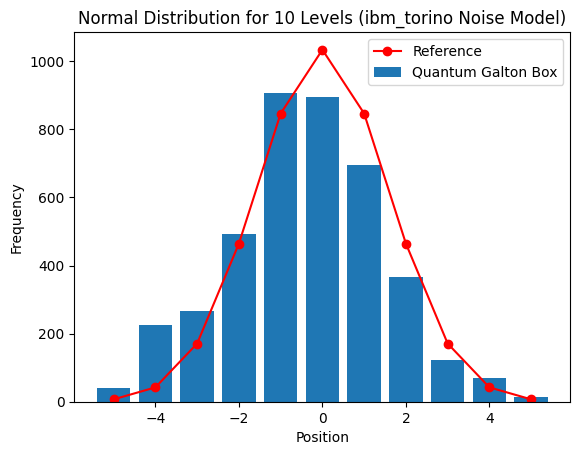

In [17]:
gaussian = dg.normal(generate_probs=True)[1]
results["gaussian_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_opt_qgb_circuit,
    optimized_coin,
    RunMode.NOISELESS_SIMULATOR,
    title=f"Normal Distribution for {n} Levels (Noiseless)",
    probs=gaussian,
)
results["gaussian_noisy"] = run_simulation(
    n,
    SHOTS,
    create_opt_qgb_circuit,
    optimized_coin,
    RunMode.NOISY_SIMULATOR,
    title=f"Normal Distribution for {n} Levels ({real_torino.name} Noise Model)",
    backend=real_torino,
    probs=gaussian,
)
if ENABLE_REAL_DEVICE:
    results["gaussian_real_device"] = run_simulation(
        n,
        SHOTS,
        create_opt_qgb_circuit,
        optimized_coin,
        RunMode.REAL_DEVICE,
        title=f"Normal Distribution for {n} Levels (Real Device: {real_torino.name})",
        backend=real_torino,
        probs=gaussian,
    )

### Exponential Distribution

We will apply the same procedure of collecting results for the exponential distribution leveraging the optimized circuit design.

Width and depth of transpiled circuit: 24, 50


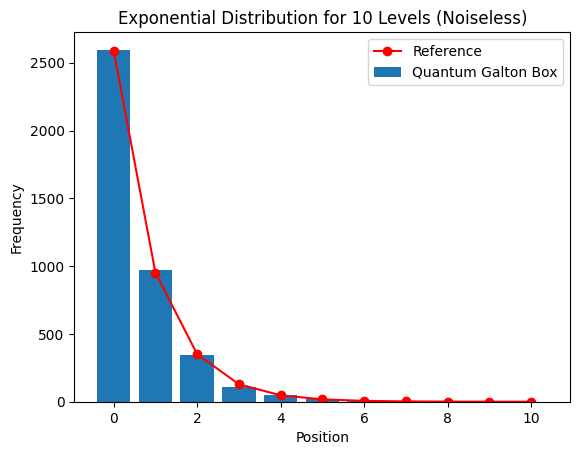

Width and depth of transpiled circuit: 144, 1171
Width and depth after AI Pass: 144, 863


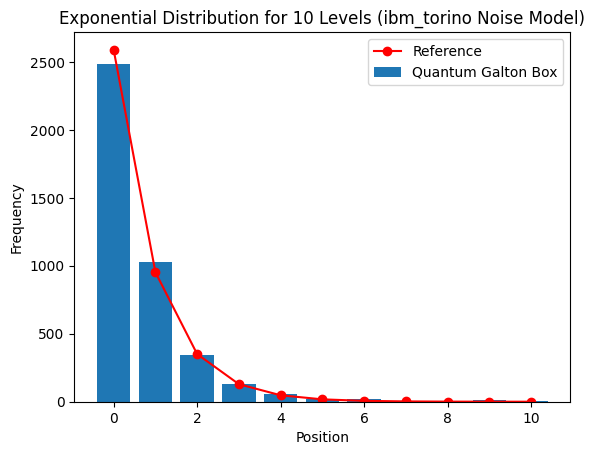

In [18]:
exponential = dg.exponential(generate_probs=True)[1]
results["exponential_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_opt_qgb_circuit,
    optimized_coin,
    RunMode.NOISELESS_SIMULATOR,
    distribution_type=DistributionType.EXPONENTIAL,
    title=f"Exponential Distribution for {n} Levels (Noiseless)",
    probs=exponential,
)
results["exponential_noisy"] = run_simulation(
    n,
    SHOTS,
    create_opt_qgb_circuit,
    optimized_coin,
    RunMode.NOISY_SIMULATOR,
    distribution_type=DistributionType.EXPONENTIAL,
    title=f"Exponential Distribution for {n} Levels ({real_torino.name} Noise Model)",
    backend=real_torino,
    probs=exponential,
)
if ENABLE_REAL_DEVICE:
    results["exponential_real_device"] = run_simulation(
        n,
        SHOTS,
        create_opt_qgb_circuit,
        optimized_coin,
        RunMode.REAL_DEVICE,
        distribution_type=DistributionType.EXPONENTIAL,
        title=f"Exponential Distribution for {n} Levels (Real Device: {real_torino.name})",
        backend=real_torino,
        probs=exponential,
    )

Now, there is a well-known implementation of Exponential distribution generation on $n$ qubits with $n$ `RY` rotations. This is the most optimal way of generating this specific distribution with only single qubit gates. The implementation is taken from the Classiq SDK.

In [19]:
# Classiq implementation
# repeat(q.len, lambda i: RY(2.0 * atan(exp((-rate * 2.0**i) / 2.0)), q[i]))
def prep_exponential(n, rate) -> QuantumCircuit:
    """Prepare exponential distribution on n qubits."""
    circuit = QuantumCircuit(n, n)
    for i in range(n):
        circuit.ry(2.0 * math.atan(math.exp((-rate * 2.0**i))), i)
    circuit.measure(range(n), range(n))
    return circuit

### Hadamard Random Walk Distribution

Width and depth of transpiled circuit: 24, 50


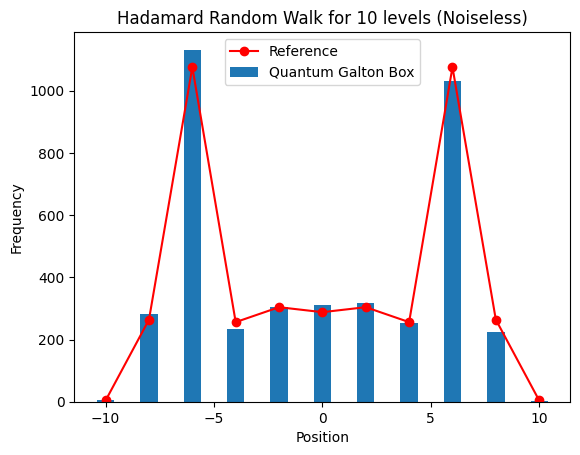

Width and depth of transpiled circuit: 144, 1171
Width and depth after AI Pass: 144, 866


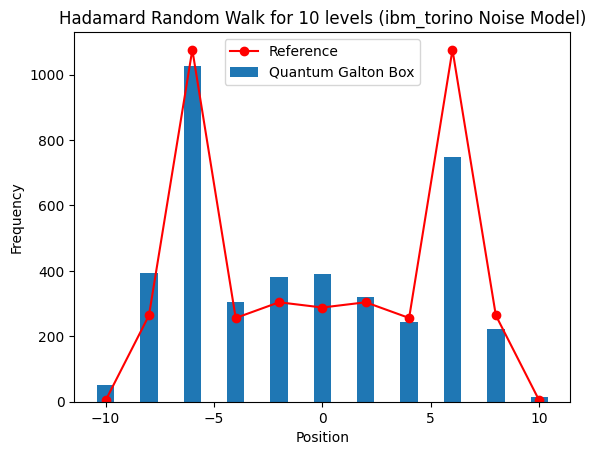

In [20]:
hadamard_probs = dg.hadamard(generate_probs=True)[1]
results["hadamard_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_opt_qgb_circuit,
    optimized_coin,
    RunMode.NOISELESS_SIMULATOR,
    distribution_type=DistributionType.HADAMARD,
    title=f"Hadamard Random Walk for {n} levels (Noiseless)",
    probs=hadamard_probs,
)
results["hadamard_noisy"] = run_simulation(
    n,
    SHOTS,
    create_opt_qgb_circuit,
    optimized_coin,
    RunMode.NOISY_SIMULATOR,
    distribution_type=DistributionType.HADAMARD,
    title=f"Hadamard Random Walk for {n} levels ({real_torino.name} Noise Model)",
    backend=real_torino,
    probs=hadamard_probs,
)
if ENABLE_REAL_DEVICE:
    results["hadamard_real_device"] = run_simulation(
        n,
        SHOTS,
        create_opt_qgb_circuit,
        optimized_coin,
        RunMode.REAL_DEVICE,
        distribution_type=DistributionType.HADAMARD,
        title=f"Hadamard Random Walk for {n} levels (Real Device: {real_torino.name})",
        backend=real_torino,
        probs=hadamard_probs,
    )

## Part V - Study the Distances between Obtained and Target Distributions

Let's now turn to understanding how well the obtained distributions are approximating the target distributions.

We have collected a hefty amount of samples for both Exponential and Hadamard Random Walk circuits executed under the noise model.

In [21]:
from scipy.stats import wasserstein_distance

In [22]:
distances = {}
for sim_name, (positions, freqs, ref_freqs) in results.items():
    quantum_freqs = np.array(list(freqs.values()))
    reference_freqs = np.array(ref_freqs)
    positions = np.array(positions)

    quantum_probs = quantum_freqs / quantum_freqs.sum()
    reference_probs = reference_freqs / reference_freqs.sum()
    distance = wasserstein_distance(
        u_values=positions,
        v_values=positions,
        u_weights=quantum_probs,
        v_weights=reference_probs,
    )
    tokens = sim_name.split("_")
    for i, t in enumerate(tokens):
        tokens[i] = t[0].upper() + t[1:]
    sim_name_printable = " ".join(tokens)
    print(f"Wasserstein Distance for {sim_name_printable:<40} {distance:.4f}")
    distances[sim_name] = distance

Wasserstein Distance for Gaussian Noiseless                       0.0166
Wasserstein Distance for Exponential Noiseless                    0.0134
Wasserstein Distance for Hadamard Noiseless                       0.2417
Wasserstein Distance for Gaussian Noisy                           0.4217
Wasserstein Distance for Exponential Noisy                        0.0771
Wasserstein Distance for Hadamard Noisy                           0.9326


In [23]:
distances = {}
for sim_name, (positions, freqs, ref_freqs) in results.items():
    quantum_freqs = np.array(list(freqs.values()))
    reference_freqs = np.array(ref_freqs)
    positions = np.array(positions)
    quantum_probs = quantum_freqs / quantum_freqs.sum()
    reference_probs = reference_freqs / reference_freqs.sum()

    mse_value = np.mean((quantum_probs - reference_probs) ** 2) * SHOTS
    metric_name = "MSE"

    # Format and output
    tokens = [t[0].upper() + t[1:] for t in sim_name.split("_")]
    sim_name_printable = " ".join(tokens)
    print(f"{metric_name} for {sim_name_printable:<40} {mse_value:.6f}")
    distances[sim_name] = mse_value

MSE for Gaussian Noiseless                       0.048312
MSE for Exponential Noiseless                    0.017954
MSE for Hadamard Noiseless                       0.179687
MSE for Gaussian Noisy                           2.269225
MSE for Exponential Noisy                        0.366701
MSE for Hadamard Noisy                           3.360002


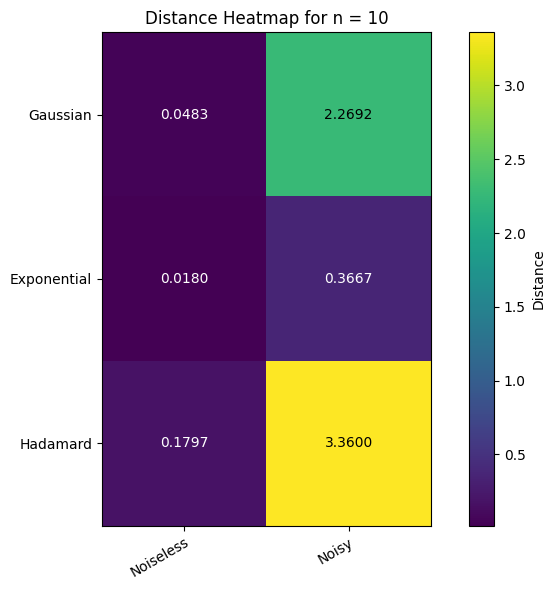

In [24]:
heat_map_distances = np.array(
    [
        [
            distances["gaussian_noiseless"],
            distances["gaussian_noisy"],
            
        ] + ([distances["gaussian_real_device"]] if ENABLE_REAL_DEVICE else []),
        [
            distances["exponential_noiseless"],
            distances["exponential_noisy"],
        ] + ([distances["exponential_real_device"]] if ENABLE_REAL_DEVICE else []),
        [
            distances["hadamard_noiseless"],
            distances["hadamard_noisy"],
        ] + ([distances["hadamard_real_device"]] if ENABLE_REAL_DEVICE else [])
    ]
)
y_labels = ["Gaussian", "Exponential", "Hadamard"]
x_labels = ["Noiseless", "Noisy"] + (["Real Device"] if ENABLE_REAL_DEVICE else [])

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(heat_map_distances, cmap="viridis")
ax.set_xticks(np.arange(len(x_labels)))
ax.set_yticks(np.arange(len(y_labels)))
ax.set_xticklabels(x_labels)
ax.set_yticklabels(y_labels)
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        ax.text(
            j,
            i,
            f"{heat_map_distances[i, j]:.4f}",
            ha="center",
            va="center",
            color="white" if heat_map_distances[i, j] < 1 else "black",
        )

# Colorbar and title
fig.colorbar(cax, label="Distance")
ax.set_title(f"Distance Heatmap for n = {n}")
plt.tight_layout()
plt.show()

In [29]:
gaussian_noisy_results = defaultdict(int)
exponential_noisy_results = defaultdict(int)
hadamard_noisy_results = defaultdict(int)
for levels in range(5, 15):
    dg = DistributionGenerator(levels, SHOTS)
    gaussian = dg.normal(generate_probs=True)[1]
    exponential = dg.exponential(generate_probs=True)[1]
    hadamard_probs = dg.hadamard(generate_probs=True)[1]
    gaussian_noisy_results[levels] = run_simulation(
        levels,
        SHOTS,
        create_opt_qgb_circuit,
        optimized_coin,
        RunMode.NOISY_SIMULATOR,
        title=f"Normal Distribution for {levels} Levels (Noisy)",
        backend=real_torino,
        distribution_type=DistributionType.NORMAL,
        probs=gaussian,
        plots=False,
    )
    exponential_noisy_results[levels] = run_simulation(
        levels,
        SHOTS,
        create_opt_qgb_circuit,
        optimized_coin,
        RunMode.NOISY_SIMULATOR,
        title=f"Exponential Distribution for {levels} Levels (Noisy)",
        backend=real_torino,
        distribution_type=DistributionType.EXPONENTIAL,
        probs=exponential,
        plots=False,
    )
    hadamard_noisy_results[levels] = run_simulation(
        levels,
        SHOTS,
        create_opt_qgb_circuit,
        optimized_coin,
        RunMode.NOISY_SIMULATOR,
        title=f"Hadamard Distribution for {levels} Levels (Noisy)",
        backend=real_torino,
        distribution_type=DistributionType.HADAMARD,
        probs=hadamard_probs,
        plots=False,
    )

Width and depth of transpiled circuit: 139, 578
Width and depth after AI Pass: 139, 424
Width and depth of transpiled circuit: 139, 578
Width and depth after AI Pass: 139, 423
Width and depth of transpiled circuit: 139, 582
Width and depth after AI Pass: 139, 435
Width and depth of transpiled circuit: 140, 696
Width and depth after AI Pass: 140, 512
Width and depth of transpiled circuit: 140, 696
Width and depth after AI Pass: 140, 511
Width and depth of transpiled circuit: 140, 700
Width and depth after AI Pass: 140, 522
Width and depth of transpiled circuit: 141, 814
Width and depth after AI Pass: 141, 598
Width and depth of transpiled circuit: 141, 814
Width and depth after AI Pass: 141, 597
Width and depth of transpiled circuit: 141, 818
Width and depth after AI Pass: 141, 612
Width and depth of transpiled circuit: 142, 932
Width and depth after AI Pass: 142, 689
Width and depth of transpiled circuit: 142, 932
Width and depth after AI Pass: 142, 687
Width and depth of transpiled ci

In [30]:
def calculate_distance(positions, freqs, reference_freqs):
    """Calculates the MSE distance between two probability distributions."""
    quantum_freqs = np.array(list(freqs.values()))
    reference_freqs = np.array(ref_freqs)
    positions = np.array(positions)
    quantum_probs = quantum_freqs / quantum_freqs.sum()
    reference_probs = reference_freqs / reference_freqs.sum()

    mse_value = np.mean((quantum_probs - reference_probs) ** 2) * SHOTS
    return mse_value

In [31]:
gaussian_distances = defaultdict(int)
exponential_distances = defaultdict(int)
hadamard_distances = defaultdict(int)
for levels, (positions, freqs, ref_freqs) in gaussian_noisy_results.items():
    gaussian_distances[levels] = calculate_distance(positions, freqs, ref_freqs)

for levels, (positions, freqs, ref_freqs) in exponential_noisy_results.items():
    exponential_distances[levels] = calculate_distance(positions, freqs, ref_freqs)

for levels, (positions, freqs, ref_freqs) in hadamard_noisy_results.items():
    hadamard_distances[levels] = calculate_distance(positions, freqs, ref_freqs)

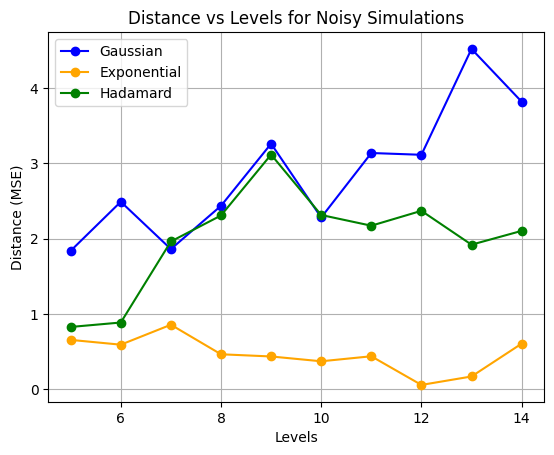

In [32]:
plt.plot(
    list(gaussian_distances.keys()),
    list(gaussian_distances.values()),
    label="Gaussian",
    marker="o",
    color="blue",
)

plt.plot(
    list(exponential_distances.keys()),
    list(exponential_distances.values()),
    label="Exponential",
    marker="o",
    color="orange",
)

plt.plot(
    list(hadamard_distances.keys()),
    list(hadamard_distances.values()),
    label="Hadamard",
    marker="o",
    color="green",
)
plt.xlabel("Levels")
plt.ylabel("Distance (MSE)")
plt.title("Distance vs Levels for Noisy Simulations")
plt.legend()
plt.grid()
plt.show()

We conclude that Exponential distribution realized the most potential from the Galton Board optimizations reducing the number of required qubits from $2n+2$ to $n+3$ and significantly lowering the depth of the circuit. It helped maintaining close enough distance from the reference distribution in the presence of noise and even on a real device.